**<h1>IMPORT LIBRARIES</h1>**

In [25]:
import re
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import BertTokenizer, TFBertModel

**<h1>READ DATASET</h1>**

In [ ]:
data = pd.read_csv('./resetted_index_cleaned_polarity_roberta.csv', index_col=0)
data

In [ ]:
pos = data[data['sentiment'] == 'positive'].head(312564)
neu = data[data['sentiment'] == 'neutral'].head(312564)
neg = data[data['sentiment'] == 'negative'].head(312564)
df = pd.concat([pos, neu, neg], ignore_index=True)

In [ ]:
df['sentiment'] = df['sentiment'].replace({'positive': 0, 'negative': 1, 'neutral': 2})
df.head()

In [ ]:
texts = df['cleaned_review'].tolist()
for index, value in enumerate(texts):
    if isinstance(value, float):
        texts[index] = str(value)

In [ ]:
labels = to_categorical(df['sentiment'])
labels = np.array(labels)

**<h1>TOKENIZATION</h1>**

In [2]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [3]:
shape = 96
batch_size = 64

In [ ]:
train_encodings = tokenizer(X_train, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')

In [ ]:
test_encodings = tokenizer(X_test, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')

## **LOAD TOKENIZATION**

In [4]:
save_path_train = './fix/train_encodings'
save_path_test = './fix/test_encodings'
save_path_y_train = './fix/y_train/y_train.tfrecord'
save_path_y_test = './fix/y_test/y_test.tfrecord'

In [5]:
serialized_tensor_train = tf.io.read_file(save_path_y_train)
serialized_tensor_test = tf.io.read_file(save_path_y_test)

In [6]:
loaded_tensor_train = tf.io.parse_tensor(serialized_tensor_train, out_type=tf.float32)
loaded_tensor_test = tf.io.parse_tensor(serialized_tensor_test, out_type=tf.float32)

In [7]:
loaded_y_train = loaded_tensor_train.numpy()
loaded_y_test = loaded_tensor_test.numpy()

In [8]:
loaded_train_encodings = {}
for key in ['input_ids', 'attention_mask', 'token_type_ids']:
    tensor = tf.io.read_file(f"{save_path_train}/{key}.tfrecord")
    loaded_train_encodings[key] = tf.io.parse_tensor(tensor, out_type=tf.int32)

In [9]:
loaded_test_encodings = {}
for key in ['input_ids', 'attention_mask', 'token_type_ids']:
    tensor = tf.io.read_file(f"{save_path_test}/{key}.tfrecord")
    loaded_test_encodings[key] = tf.io.parse_tensor(tensor, out_type=tf.int32)

**<h1>CONVERT TO TENSORFLOW DATASET</h1>**

In [10]:
def create_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'token_type_ids': encodings['token_type_ids']
        },
        tf.constant(labels)
    )).batch(batch_size, drop_remainder=True)

In [11]:
train_tf_dataset = create_tf_dataset(loaded_train_encodings, loaded_y_train)
test_tf_dataset = create_tf_dataset(loaded_test_encodings, loaded_y_test)

**<h1>WORD EMBEDDING</h1>**

In [12]:
def get_bert_embeddings_in_batches(encodings, batch_size=batch_size):
    embeddings = []
    num_samples = len(encodings['input_ids'])

    for i in range(0, num_samples, batch_size):
        batch_input_ids = encodings['input_ids'][i:i+batch_size]
        batch_attention_mask = encodings['attention_mask'][i:i+batch_size]
        batch_token_type_ids = encodings['token_type_ids'][i:i+batch_size]

        batch_inputs = {
            'input_ids': tf.convert_to_tensor(batch_input_ids),
            'attention_mask': tf.convert_to_tensor(batch_attention_mask),
            'token_type_ids': tf.convert_to_tensor(batch_token_type_ids)
        }

        outputs = model(batch_inputs)
        batch_cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token embeddings

        embeddings.append(batch_cls_embeddings)

    return tf.concat(embeddings, axis=0)

In [18]:
train_embeddings = get_bert_embeddings_in_batches(loaded_train_encodings, batch_size=batch_size)
test_embeddings = get_bert_embeddings_in_batches(loaded_test_encodings, batch_size=batch_size)

## **SAVE EMBEDDINGS**

In [ ]:
tf.io.write_file('./fix/bert_train_embeddings_tf.bin', tf.io.serialize_tensor(train_embeddings))

In [ ]:
tf.io.write_file('./fix/bert_test_embeddings_tf.bin', tf.io.serialize_tensor(test_embeddings))

## **LOAD EMBEDDINGS**

In [13]:
train_embeddings_loaded = tf.io.parse_tensor(tf.io.read_file('./fix/bert_train_embeddings_tf.bin'), out_type=tf.float32)
test_embeddings_loaded = tf.io.parse_tensor(tf.io.read_file('./fix/bert_test_embeddings_tf.bin'), out_type=tf.float32)

In [14]:
train_embeddings_np = train_embeddings_loaded.numpy()
test_embeddings_np = test_embeddings_loaded.numpy()

**<h1>RANDOM FOREST</h1>**

In [15]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [16]:
rf_classifier.fit(train_embeddings_np, loaded_y_train)

RandomForestClassifier(random_state=42)

In [17]:
y_pred = rf_classifier.predict(test_embeddings_np)

In [18]:
accuracy = accuracy_score(loaded_y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.4089


**<h1>EVALUATION</h1>**

In [19]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [20]:
y_test_labels = loaded_y_test.argmax(axis=1)

In [21]:
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

In [22]:
class_labels = ['Positive', 'Negative', 'Neutral']

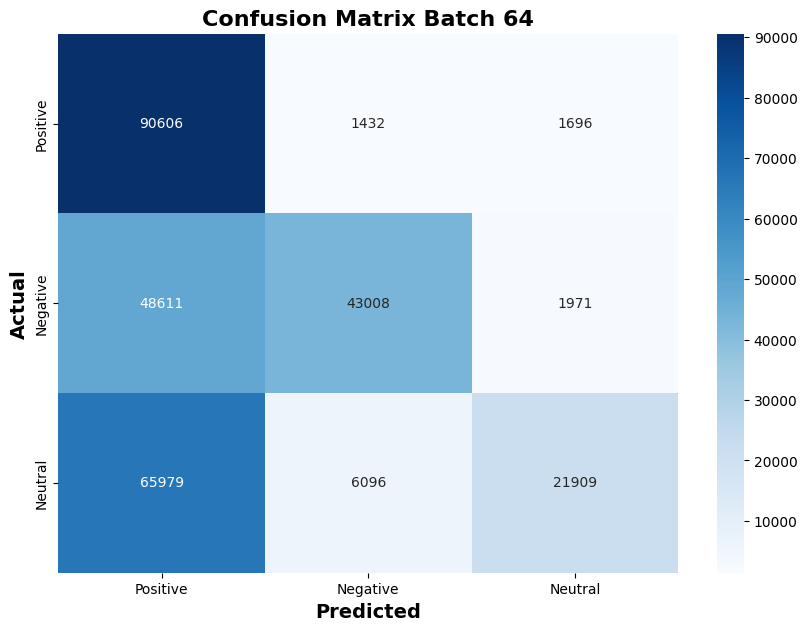

In [28]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix Batch 64', fontsize=16, fontweight='bold')
plt.show()

In [24]:
print(classification_report(y_test_labels, y_pred_labels, target_names=['Positive', 'Negative', 'Neutral']))

              precision    recall  f1-score   support

    Positive       0.44      0.97      0.61     93734
    Negative       0.85      0.46      0.60     93590
     Neutral       0.86      0.23      0.37     93984

    accuracy                           0.55    281308
   macro avg       0.72      0.55      0.52    281308
weighted avg       0.72      0.55      0.52    281308



**<h1>SAVE MODEL</h1>**

In [27]:
dump(rf_classifier, 'random_forest_alone.joblib')

['random_forest_alone.joblib']

**<h1>LOAD MODEL</h1>**

In [ ]:
loaded_rf_model = load('random_forest_alone.joblib')

In [ ]:
y_pred_loaded = loaded_rf_model.predict(test_embeddings_np)